In [2]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import f1_score, roc_curve, auc

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers

import pickle

### Reading in the data

In [3]:
directory = './data/'
file = 'diabetes.csv'
diabetes = pd.read_csv(directory+file)

In [4]:
diabetes.sample( 5 )

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
148,5,147,78,0,0,33.7,0.218,65,0
425,4,184,78,39,277,37.0,0.264,31,1
759,6,190,92,0,0,35.5,0.278,66,1
67,2,109,92,0,0,42.7,0.845,54,0
105,1,126,56,29,152,28.7,0.801,21,0


### Checking if there are missing values

In [5]:
info = pd.DataFrame( diabetes.dtypes , columns = [ 'Data_Types' ]) 
info['Null_Values'] = diabetes.isnull().sum()
info['Mean'] = diabetes.describe().loc['mean']
info['Deviation'] = diabetes.describe().loc['std']
info

,Data_Types,Null_Values,Mean,Deviation
Pregnancies,int64,0,3.845052,3.369578
Glucose,int64,0,120.894531,31.972618
BloodPressure,int64,0,69.105469,19.355807
SkinThickness,int64,0,20.536458,15.952218
Insulin,int64,0,79.799479,115.244002
BMI,float64,0,31.992578,7.884160
DiabetesPedigreeFunction,float64,0,0.471876,0.331329
Age,int64,0,33.240885,11.760232
Outcome,int64,0,0.348958,0.476951


## Data Visualization 

### Bar graph of positive and negative outcommes

 Diabetic cases     : 268 
 Non-diabetic cases : 500


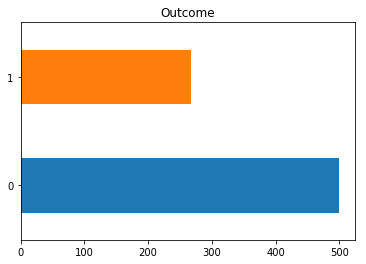

In [6]:
negative, positive = diabetes['Outcome'].value_counts()
print(' Diabetic cases     : {0} \n Non-diabetic cases : {1}'.format(positive, negative))
diabetes['Outcome'].value_counts().plot(kind='barh', title='Outcome')

### Box plots of the non-standardized data 

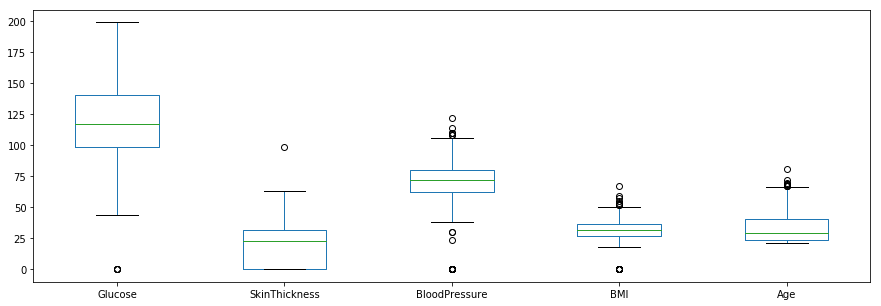

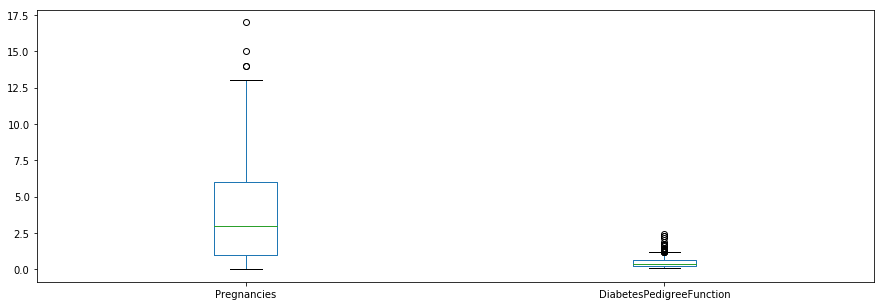

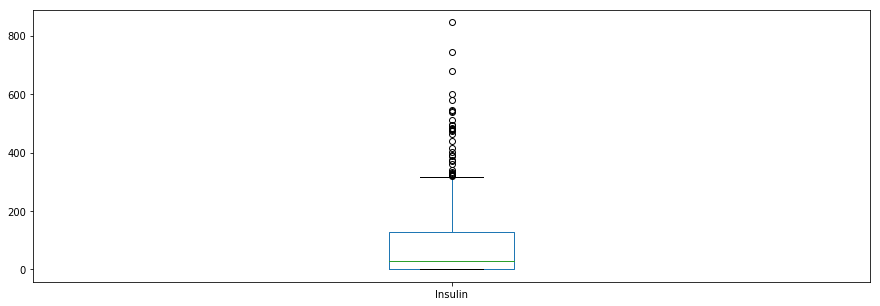

In [7]:
diabetes.loc[:,['Glucose','SkinThickness','BloodPressure','BMI','Age']].plot.box( figsize=(15,5) )
diabetes.loc[:,['Pregnancies','DiabetesPedigreeFunction']].plot.box( figsize=(15,5) )
diabetes.loc[:,['Insulin']].plot.box( figsize=(15,5) ) 

### Violin and swarm plot of the standardized data 

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

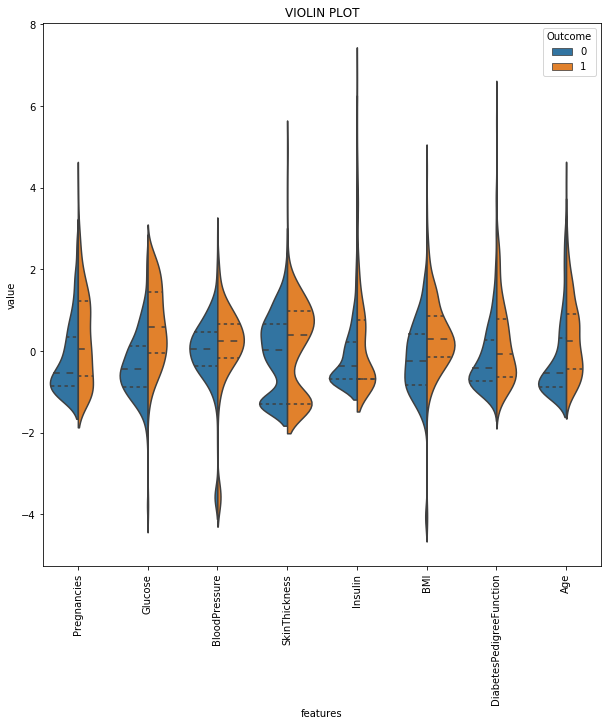

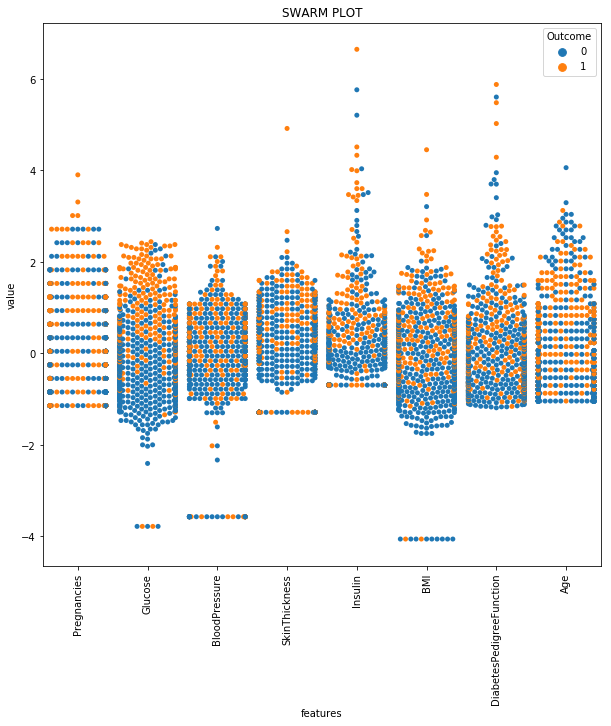

In [7]:
targets = diabetes.iloc[:,-1] 
features = diabetes.iloc[:,0:-1]
normalized = (features - features.mean()) / ( features.std() )  
data = pd.concat([ targets , normalized ], axis=1)
violin_data = pd.melt( data, id_vars="Outcome", var_name="features", value_name='value')
swarm_data  = pd.melt( data, id_vars="Outcome", var_name="features", value_name='value')

plt.figure(figsize=(10,10))
plt.title("VIOLIN PLOT")
sns.violinplot(x="features", y="value", hue="Outcome", data=violin_data, split=True, inner="quart")
plt.xticks(rotation=90)

plt.figure(figsize=(10,10))
plt.title("SWARM PLOT")
sns.swarmplot(x="features", y="value", hue="Outcome", data=swarm_data)
plt.xticks(rotation=90)

## Building the classification model

### Preparing the data

In [9]:
X = diabetes.iloc[:,0:-1].values
y = diabetes.iloc[:,-1].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#Saving the scaler in a file in the "data" directory 
with open("./data/scaler.pkl","wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_scaled, y, test_size=0.2, random_state=4)

### Defining a crude multilayer perceptron classfier 

In [10]:
model = Sequential()
model.add( Dense(32, input_dim=8, activation='relu', kernel_regularizer=regularizers.l2(0.01) ))
model.add( Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.1) ) )
model.add( Dense(1, activation='sigmoid' ))
model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Running the optimizer

In [10]:
model.fit(X_train, y_train , epochs=100, batch_size=20, verbose=0)

### Evaluating performance of the trained model 

#### Accuracy and F1 score

In [11]:
decision_threshold = 0.5
predictions = (model.predict(X_test, verbose=0) > decision_threshold ).astype(int).flatten()

accuracy = (predictions == y_test).sum() * 1.0 / y_test.shape[0]
print("Accuracy on the test data = {0}".format(accuracy))

f1 = f1_score(y_test, predictions ) 
print("F1 score of the binary classfication = {0}".format(f1))


Accuracy on the test data = 0.7792207792207793
F1 score of the binary classfication = 0.6458333333333334


#### ROC Curve

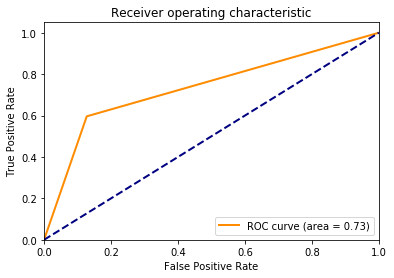

In [12]:
fpr , tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0]) ; plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate') ; plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic') ; plt.legend(loc="lower right")
plt.show()

## Saving the model & the StandardScaler to disk 

In [13]:
"""model_json = model.to_json()
with open("diabetes_classification_model.json",'w') as json_file:
    json_file.write(model_json)
    
"""